In [1]:
from tqdm.autonotebook import tqdm
import torchxrayvision as xrv
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import tarfile
from pathlib import Path

## Extracting and Loading X-Ray Data

Using previously extracted files...
Loading dataset from ./data/NIH/extracted/images-224
Dataset size: 28868

Available pathologies:
1. Atelectasis
2. Cardiomegaly
3. Consolidation
4. Edema
5. Effusion
6. Emphysema
7. Fibrosis
8. Hernia
9. Infiltration
10. Mass
11. Nodule
12. Pleural_Thickening
13. Pneumonia
14. Pneumothorax

Pathology counts:
Atelectasis:
  Present: 1557
  Absent: 27311
  Percentage: 5.39%

Cardiomegaly:
  Present: 729
  Absent: 28139
  Percentage: 2.53%

Consolidation:
  Present: 384
  Absent: 28484
  Percentage: 1.33%

Edema:
  Present: 39
  Absent: 28829
  Percentage: 0.14%

Effusion:
  Present: 1269
  Absent: 27599
  Percentage: 4.40%

Emphysema:
  Present: 264
  Absent: 28604
  Percentage: 0.91%

Fibrosis:
  Present: 556
  Absent: 28312
  Percentage: 1.93%

Hernia:
  Present: 81
  Absent: 28787
  Percentage: 0.28%

Infiltration:
  Present: 3273
  Absent: 25595
  Percentage: 11.34%

Mass:
  Present: 1213
  Absent: 27655
  Percentage: 4.20%

Nodule:
  Present: 1609

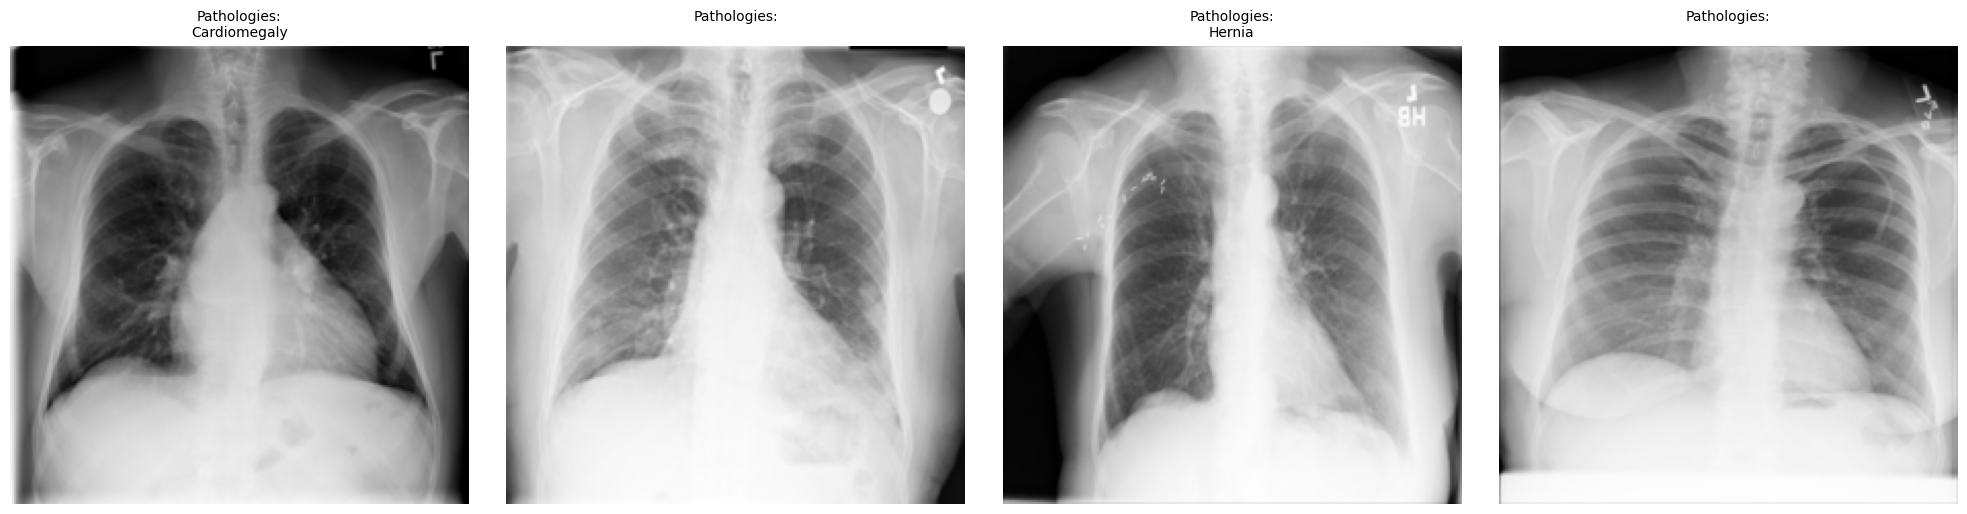

In [2]:
def extract_tar_if_needed(tar_path, extract_dir):
    """
    Extract tar file if it hasn't been extracted already
    
    Parameters:
    tar_path (str): Path to the tar file
    extract_dir (str): Directory to extract to
    
    Returns:
    str: Path to the directory containing the extracted images
    """
    # Create extract directory if it doesn't exist
    Path(extract_dir).mkdir(parents=True, exist_ok=True)
    
    # Check if files are already extracted
    images_dir = os.path.join(extract_dir, 'images-224')
    if os.path.exists(images_dir) and len(os.listdir(images_dir)) > 0:
        print("Using previously extracted files...")
        return images_dir
    
    print(f"Extracting {tar_path} to {extract_dir}...")
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_dir)
    
    return images_dir

def load_nih_dataset(
    imgpath,
    extract_dir="./data/NIH/extracted",
    views=['PA'],
    unique_patients=True,
    transform=None,
    batch_size=32,
    pathology_masks=False
):
    """
    Load the NIH ChestX-ray14 dataset using TorchXRayVision
    
    Parameters:
    imgpath (str): Path to either the tar file or directory containing NIH dataset images
    extract_dir (str): Directory to extract tar file to if needed
    views (list): List of views to include (default: ['PA'])
    unique_patients (bool): Whether to include only unique patients (default: True)
    transform: Optional transforms to apply (default: None)
    batch_size (int): Batch size for data loader (default: 32)
    pathology_masks (bool): Whether to include pathology masks (default: False)
    
    Returns:
    dataset: NIH_Dataset object
    dataloader: DataLoader object
    """
    # Handle tar file if provided
    if imgpath.endswith('.tar'):
        images_dir = extract_tar_if_needed(imgpath, extract_dir)
    else:
        images_dir = imgpath
    
    # Verify the directory exists and contains images
    if not os.path.isdir(images_dir):
        raise Exception(f"Could not find valid directory at {images_dir}")
    
    print(f"Loading dataset from {images_dir}")
    
    # Initialize the NIH dataset
    dataset = xrv.datasets.NIH_Dataset(
        imgpath=images_dir,
        views=views,
        unique_patients=unique_patients,
        transform=transform,
        pathology_masks=pathology_masks
    )
    
    # Create data loader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )
    
    return dataset, dataloader

def print_dataset_info(dataset):
    """
    Print information about the dataset
    
    Parameters:
    dataset: NIH_Dataset object
    """
    print(f"Dataset size: {len(dataset)}")
    print(f"\nAvailable pathologies:")
    for i, pathology in enumerate(dataset.pathologies):
        print(f"{i+1}. {pathology}")
    
    print("\nPathology counts:")
    totals = dataset.totals()
    for pathology in totals:
        present = totals[pathology].get(1.0, 0)
        absent = totals[pathology].get(0.0, 0)
        print(f"{pathology}:")
        print(f"  Present: {present}")
        print(f"  Absent: {absent}")
        print(f"  Percentage: {(present/(present+absent))*100:.2f}%\n")

def show_sample_images(dataset, num_samples=4):
    """
    Display sample images from the dataset
    
    Parameters:
    dataset: NIH_Dataset object
    num_samples (int): Number of samples to display
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        # Get sample and print its structure to debug
        sample = dataset[i]
        print(f"Sample {i} structure:", sample.keys() if hasattr(sample, 'keys') else type(sample))
        
        try:
            if isinstance(sample, dict):
                # If it's a dictionary
                img = sample['img'] if 'img' in sample else sample['image']
                label = sample['lab'] if 'lab' in sample else sample['label']
            else:
                # If it's any other type of sequence
                img, label = sample
            
            if isinstance(img, torch.Tensor):
                img = img.numpy()
            
            # Display the image
            axes[i].imshow(img[0] if img.ndim > 2 else img, cmap='gray')
            axes[i].axis('off')
            
            # Get pathologies present in this image
            pathologies_present = [
                dataset.pathologies[j] 
                for j in range(len(label)) 
                if label[j] == 1
            ]
            
            axes[i].set_title(
                "Pathologies:\n" + "\n".join(pathologies_present),
                fontsize=10
            )
        except Exception as e:
            print(f"Error processing sample {i}:", e)
            print("Sample content:", sample)
    
    plt.tight_layout()
    plt.show()

imgpath = "./data/NIH/images-224.tar"

# Load dataset
dataset, dataloader = load_nih_dataset(
    imgpath=imgpath,
    extract_dir="./data/NIH/extracted",
    views=['PA'],
    unique_patients=True
)

# Print dataset information
print_dataset_info(dataset)

# Show sample images
show_sample_images(dataset)

## Loading Pre-trained Dense Net Model

In [3]:
model = xrv.models.DenseNet(weights="densenet121-res224-nih")

## Running Base Inference Pipeline with Model

Dataset structure:
Using subset dataset
Original dataset type: <class 'torchxrayvision.datasets.NIH_Dataset'>

Number of pathologies: 14
Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Batch information:
Batch type: <class 'dict'>
Batch keys: dict_keys(['idx', 'lab', 'img'])
Images shape: torch.Size([4, 1, 224, 224])
Labels shape: torch.Size([4, 14])

Predictions shape: (4, 18)

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', '', '', '', '']

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumotho

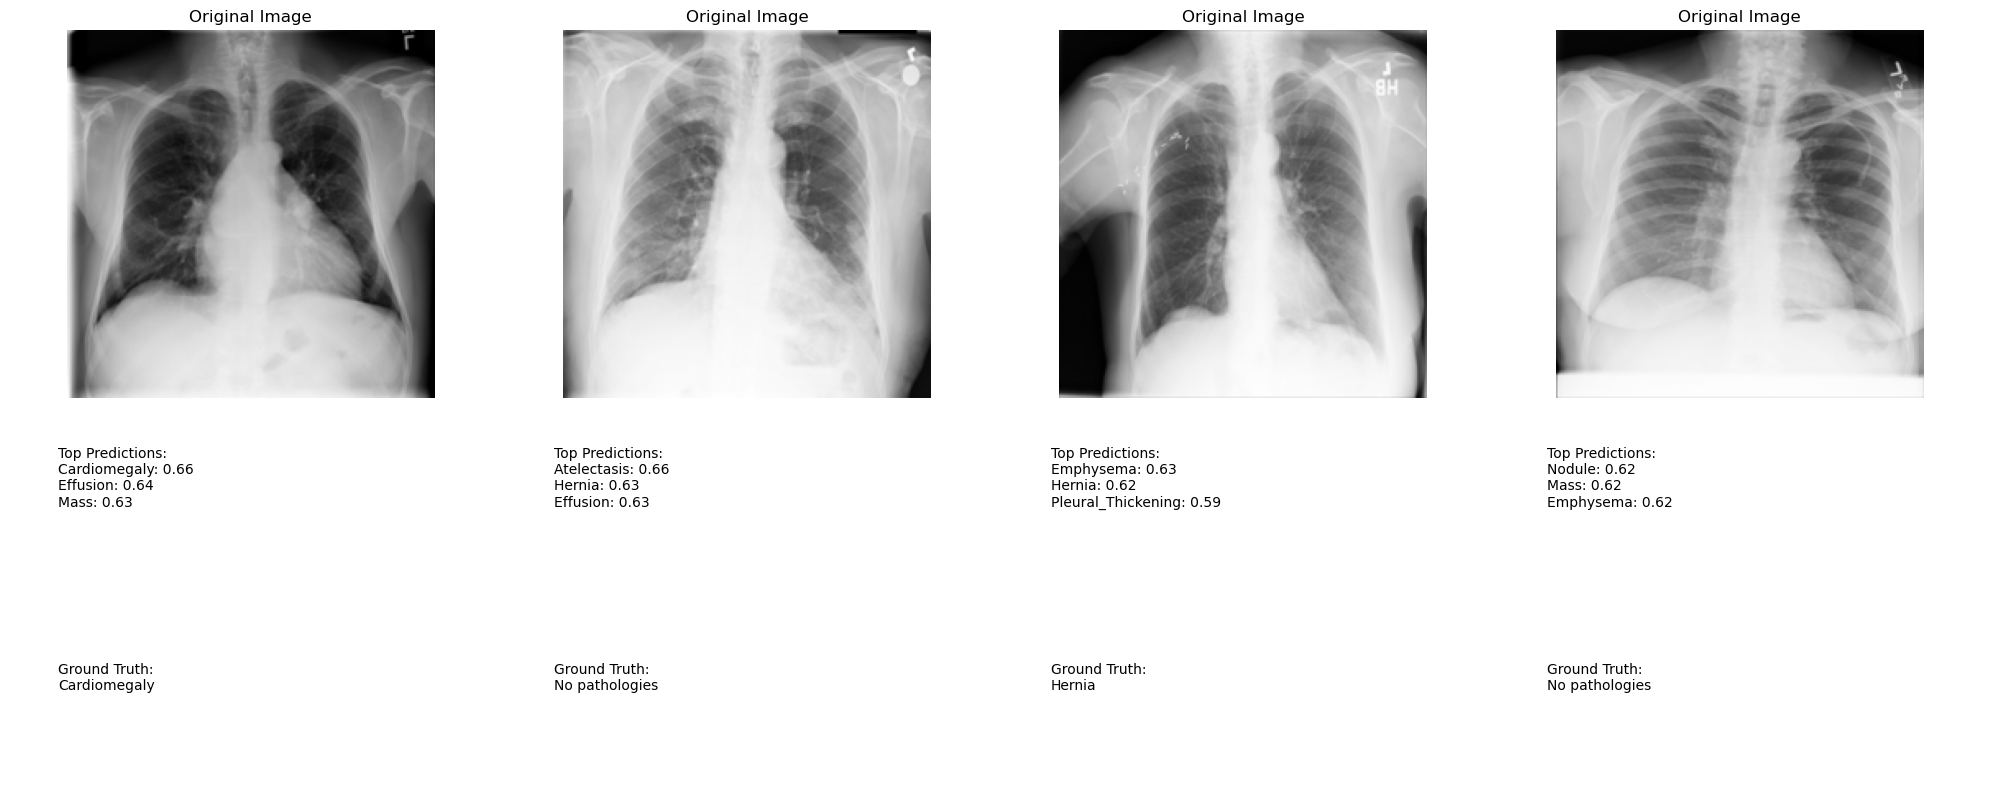

In [4]:
import torch
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

def run_inference(model, dataloader, num_samples=4, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Run inference on images and visualize results
    
    Parameters:
    model: Pre-trained torchxrayvision model
    dataloader: DataLoader containing the images
    num_samples: Number of samples to visualize
    device: Device to run inference on
    """
    model = model.to(device)
    model.eval()
    
    # Debug print dataset structure
    print("Dataset structure:")
    if hasattr(dataloader.dataset, 'dataset'):
        print("Using subset dataset")
        print(f"Original dataset type: {type(dataloader.dataset.dataset)}")
        if hasattr(dataloader.dataset.dataset, 'pathologies'):
            pathologies = list(dataloader.dataset.dataset.pathologies)
        else:
            print("Warning: No pathologies found in dataset")
    else:
        print(f"Dataset type: {type(dataloader.dataset)}")
        if hasattr(dataloader.dataset, 'pathologies'):
            pathologies = list(dataloader.dataset.pathologies)
        else:
            print("Warning: No pathologies found in dataset")
    
    # Default NIH pathologies if none found
    if not pathologies:
        pathologies = [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
            'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
        ]
    
    print(f"\nNumber of pathologies: {len(pathologies)}")
    print("Pathologies:", pathologies)
    
    # Get a batch of images
    try:
        batch = next(iter(dataloader))
        print("\nBatch information:")
        print(f"Batch type: {type(batch)}")
        
        if isinstance(batch, dict):
            print("Batch keys:", batch.keys())
            images = batch['img'][:num_samples]
            true_labels = batch['lab'][:num_samples]
        else:
            print("Batch length:", len(batch))
            images, true_labels = batch
            images = images[:num_samples]
            true_labels = true_labels[:num_samples]
        
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {true_labels.shape}")
        
        # Validate shapes match pathologies
        assert true_labels.shape[1] == len(pathologies), \
            f"Mismatch between number of labels ({true_labels.shape[1]}) and pathologies ({len(pathologies)})"
        
        images = images.to(device)
        
        # Run inference
        with torch.no_grad():
            predictions = model(images)
            predictions = torch.sigmoid(predictions).cpu().numpy()
            true_labels = true_labels.cpu().numpy()
        
        print(f"\nPredictions shape: {predictions.shape}")
        
        # Visualize results
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
        
        for i in range(num_samples):
            # Display original image
            img = images[i].cpu().numpy()
            axes[0, i].imshow(img[0], cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original Image')
            
            # Get predictions for this image
            img_preds = predictions[i]
            img_true = true_labels[i]
            
            print(f"\nDebug - Prediction vector length: {len(img_preds)}")
            print(f"Debug - Number of pathologies: {len(pathologies)}")
            
            # Get model's pathologies
            model_pathologies = model.pathologies
            print(f"Debug - Model pathologies: {model_pathologies}")
            
            # Create mapping between model and dataset pathologies
            pathology_mapping = {i: model_pathologies.index(p) for i, p in enumerate(pathologies) if p in model_pathologies}
            
            # Map predictions to our pathology list
            mapped_preds = np.zeros(len(pathologies))
            for dataset_idx, model_idx in pathology_mapping.items():
                mapped_preds[dataset_idx] = img_preds[model_idx]
            
            # Find top 3 predicted pathologies
            top_pred_idx = np.argsort(mapped_preds)[-3:][::-1]
            
            pred_text = "Top Predictions:\n"
            for idx in top_pred_idx:
                pred_text += f"{pathologies[idx]}: {mapped_preds[idx]:.2f}\n"
            
            # Find actual pathologies
            true_path_idx = np.where(img_true == 1)[0]
            true_text = "Ground Truth:\n"
            if len(true_path_idx) > 0:
                for idx in true_path_idx:
                    true_text += f"{pathologies[idx]}\n"
            else:
                true_text += "No pathologies\n"
            
            # Add texts to plot
            axes[1, i].text(0.1, 0.7, pred_text, transform=axes[1, i].transAxes)
            axes[1, i].text(0.1, 0.2, true_text, transform=axes[1, i].transAxes)
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\nError during inference: {str(e)}")
        raise

def calculate_metrics(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Calculate model performance metrics on the dataset
    
    Parameters:
    model: Pre-trained torchxrayvision model
    dataloader: DataLoader containing the images
    device: Device to run inference on
    
    Returns:
    dict: Dictionary containing performance metrics
    """
    model = model.to(device)
    model.eval()
    
    # Get pathologies list
    if hasattr(dataloader.dataset, 'dataset'):
        pathologies = dataloader.dataset.dataset.pathologies
    elif hasattr(dataloader.dataset, 'pathologies'):
        pathologies = dataloader.dataset.pathologies
    else:
        pathologies = [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
            'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
        ]
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating metrics"):
            if isinstance(batch, dict):
                images = batch['img']
                labels = batch['lab']
            else:
                images, labels = batch
            
            images = images.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs)
            
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Combine all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Calculate metrics
    metrics = {}
    
    for i, pathology in enumerate(pathologies):
        # Calculate accuracy for each pathology
        pred_binary = (all_preds[:, i] > 0.5).astype(int)
        accuracy = np.mean(pred_binary == all_labels[:, i])
        
        # Store metrics
        metrics[pathology] = {
            'accuracy': accuracy,
            'positive_samples': np.sum(all_labels[:, i] == 1),
            'negative_samples': np.sum(all_labels[:, i] == 0)
        }
    
    return metrics

# Create a small subset for testing
small_subset = torch.utils.data.Subset(dataset, indices=range(4))  # Just 4 samples
test_loader = DataLoader(small_subset, batch_size=4)

# Run inference
run_inference(model, test_loader, num_samples=4)

## Taking subset and splitting into train and test

In [5]:
train_dataset = torch.utils.data.Subset(dataset, indices=range(1000))
train_loader = DataLoader(train_dataset, batch_size=4)

test_dataset = torch.utils.data.Subset(dataset, indices=range(1000, 1500))
test_loader = DataLoader(test_dataset, batch_size=4)

## Bayesian Estimator

In [6]:
import time
import torch
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

def extract_features(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract features from images using the pretrained model
    
    Parameters:
    model: Pretrained torchxrayvision model
    dataloader: DataLoader containing the images
    device: Device to run inference on
    
    Returns:
    features: Extracted features (n_samples, n_features)
    labels: Ground truth labels (n_samples, n_classes)
    """
    model = model.to(device)
    model.eval()
    
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            if isinstance(batch, dict):
                images = batch['img']
                labels = batch['lab']
            else:
                images, labels = batch
            
            images = images.to(device)
            
            # Forward pass through the model
            features = model.features(images)
            
            # Global average pooling
            features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
            
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(features_list), np.concatenate(labels_list)

def reduce_dimensions(features, method='pca', n_components=100, random_state=42):
    """
    Reduce dimensionality of features
    
    Parameters:
    features: Feature matrix (n_samples, n_features)
    method: Dimensionality reduction method ('pca', 'tsne', or 'umap')
    n_components: Number of components to keep
    random_state: Random seed for reproducibility
    
    Returns:
    reduced_features: Reduced feature matrix (n_samples, n_components)
    reducer: Fitted dimensionality reduction model
    """
    # First, standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply dimensionality reduction
    if method.lower() == 'pca':
        reducer = PCA(n_components=n_components, random_state=random_state)
        reduced_features = reducer.fit_transform(scaled_features)
        # Print explained variance ratio
        explained_var = np.sum(reducer.explained_variance_ratio_)
        print(f"PCA with {n_components} components explains {explained_var:.2%} of variance")
    
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=random_state)
        reduced_features = reducer.fit_transform(scaled_features)
    
    elif method.lower() == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_components=n_components, random_state=random_state)
            reduced_features = reducer.fit_transform(scaled_features)
        except ImportError:
            print("UMAP not installed. Please install it with 'pip install umap-learn'")
            print("Falling back to PCA...")
            reducer = PCA(n_components=n_components, random_state=random_state)
            reduced_features = reducer.fit_transform(scaled_features)
    
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    return reduced_features, reducer, scaler

def discretize_features(features, n_bins=5):
    """
    Discretize continuous features into bins for Bayesian network
    
    Parameters:
    features: Continuous feature matrix
    n_bins: Number of bins for discretization
    
    Returns:
    discretized: Discretized feature matrix
    bin_edges: Edges of the bins for each feature
    """
    discretized = np.zeros_like(features, dtype=int)
    bin_edges = []
    
    for i in range(features.shape[1]):
        hist, edges = np.histogram(features[:, i], bins=n_bins)
        discretized[:, i] = np.digitize(features[:, i], edges[:-1])
        bin_edges.append(edges)
    
    return discretized, bin_edges


def save_model_and_metadata(model, bin_edges, reducer, scaler, param_samples, output_dir, method):
    """
    Save model with additional metadata
    
    Parameters:
    model: Bayesian network model
    bin_edges: Bin edges for discretization
    reducer: Fitted dimensionality reduction model
    scaler: Fitted scaler model
    param_samples: Dictionary of parameter samples
    output_dir: Directory to save models and metadata
    method: Dimensionality reduction method used
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    print("Saving model and metadata...")
    start_time = time.time()
    model.save(os.path.join(output_dir, 'bayesian_network_train.bif'), filetype='bif')
    
    # Save metadata
    np.save(os.path.join(output_dir, 'bin_edges_train.npy'), bin_edges)
    
    # Save dimensionality reduction models
    if method.lower() == 'pca':
        np.save(os.path.join(output_dir, 'pca_components_train.npy'), reducer.components_)
        np.save(os.path.join(output_dir, 'pca_mean_train.npy'), reducer.mean_)
        np.save(os.path.join(output_dir, 'explained_variance_train.npy'), reducer.explained_variance_ratio_)
    
    # Save scaler parameters
    np.save(os.path.join(output_dir, 'scaler_mean_train.npy'), scaler.mean_)
    np.save(os.path.join(output_dir, 'scaler_scale_train.npy'), scaler.scale_)
    
    # Save parameter samples (this might be large)
    try:
        np.save(os.path.join(output_dir, 'parameter_samples_train.npy'), param_samples)
    except:
        print("Warning: Could not save parameter samples due to size or format. Consider saving them separately.")
    
    print(f"Model and metadata saved in {time.time() - start_time:.1f} seconds")

In [7]:
print("Extracting features...")
features, labels = extract_features(model, train_loader)

Extracting features...


Extracting features:   0%|          | 0/250 [00:00<?, ?it/s]

In [8]:
reduced_features, reducer, scaler = reduce_dimensions(
    features, 
    n_components=25
)

PCA with 25 components explains 94.98% of variance


In [9]:
print("Discretizing features...")
discretized_features, bin_edges = discretize_features(reduced_features)

Discretizing features...


In [10]:
def construct_bayesian_network_with_uncertainty(features, labels, pathologies, n_bins=5, equivalent_sample_size=10, n_parameter_samples=1000):
    """
    Construct a Bayesian network from features and labels with full parameter uncertainty
    
    Parameters:
    features: Discretized feature matrix
    labels: Binary label matrix
    pathologies: List of pathology names
    n_bins: Number of bins used in discretization
    equivalent_sample_size: Parameter for Dirichlet prior strength
    n_parameter_samples: Number of parameter samples to draw from posterior distributions
    
    Returns:
    model: fitted Bayesian network
    param_samples: Dictionary of parameter samples for each node
    """
    # Create DataFrame for pgmpy
    feature_cols = [f'f{i}' for i in range(features.shape[1])]
    pathology_cols = pathologies
    
    data = pd.DataFrame(
        np.hstack([features, labels]),
        columns=feature_cols + pathology_cols
    )
    
    # Convert data types to integers (required for Bayesian estimation)
    for col in data.columns:
        data[col] = data[col].astype(int)
    
    # Define network structure
    # For simplicity, we'll create a naive Bayes structure for each pathology
    edges = []
    for p in pathology_cols:
        for f in feature_cols:
            edges.append((p, f))
    
    # Create Bayesian network
    model = BayesianNetwork(edges)
    
    # Calculate state cardinalities for each node
    state_names = {}
    for col in pathology_cols:
        state_names[col] = sorted(data[col].unique())
    
    for col in feature_cols:
        state_names[col] = sorted(data[col].unique())
        
    # Calculate node cardinalities
    node_card = {node: len(states) for node, states in state_names.items()}
    
    # Fit model with Bayesian parameter estimation
    print("Performing Bayesian parameter estimation...")
    bayes_est = BayesianEstimator(model=model, data=data)
    
    # Store parameter posterior distributions and sample from them
    param_samples = {}
    
    for node in tqdm(model.nodes(), desc="Sampling parameters"):
        # Get Dirichlet posterior parameters for this node
        # The BayesianEstimator returns Dirichlet parameters when using dirichlet prior
        cpd = bayes_est.estimate_cpd(
            node, 
            prior_type="dirichlet", 
            pseudo_counts=equivalent_sample_size
        )
        
        # Add CPD to model (this is the expected value, but we'll use samples later for inference)
        model.add_cpds(cpd)
        
        # Extract parameters from CPD
        values = cpd.values
        
        # For each configuration of parent variables, sample from Dirichlet distribution
        param_samples[node] = {}
        
        # Get parent nodes from model structure
        parents = model.get_parents(node)
        
        if parents:
            # Get cardinality of parent variables
            evidence_card = [node_card[parent] for parent in parents]
            
            # Calculate total number of parent configurations
            n_parent_configs = np.prod(evidence_card)
            
            # Reshape parameter values for sampling
            # In pgmpy, TabularCPD.values has shape [variable_cardinality, parent_cardinality]
            # We need to reshape this for sampling
            if len(parents) > 1:
                # Multiple parents case
                values_reshaped = values.reshape(node_card[node], -1)
                values_reshaped = values_reshaped.T  # Transpose to get [parent_configs, node_states]
            else:
                # Single parent case
                values_reshaped = values.T  # Just transpose to get [parent_configs, node_states]
            
            # Sample from Dirichlet for each parent configuration
            for i in range(n_parent_configs):
                # Add 1 for smoothing to avoid zero probabilities
                alpha = values_reshaped[i] * equivalent_sample_size + 1
                param_samples[node][i] = np.random.dirichlet(alpha, size=n_parameter_samples)
        else:
            # No parents, just one Dirichlet distribution
            # In this case, values has shape [variable_cardinality, 1]
            alpha = values.flatten() * equivalent_sample_size + 1  # Add 1 for smoothing
            param_samples[node][0] = np.random.dirichlet(alpha, size=n_parameter_samples)
    
    return model, param_samples, data, feature_cols, pathology_cols

pathologies = dataset.pathologies
print("Constructing Bayesian network with parameter uncertainty...")
bayes_net, param_samples, data, feature_cols, pathology_cols = construct_bayesian_network_with_uncertainty(
    discretized_features, 
    labels,
    pathologies
)

Constructing Bayesian network with parameter uncertainty...
Performing Bayesian parameter estimation...


Sampling parameters:   0%|          | 0/39 [00:00<?, ?it/s]


Processing sample 427 with features: {'f0': 3, 'f1': 4, 'f2': 4, 'f3': 3, 'f4': 3, 'f5': 2, 'f6': 3, 'f7': 4, 'f8': 2, 'f9': 3, 'f10': 2, 'f11': 2, 'f12': 3, 'f13': 4, 'f14': 2, 'f15': 3, 'f16': 4, 'f17': 3, 'f18': 1, 'f19': 3, 'f20': 2, 'f21': 3, 'f22': 4, 'f23': 4, 'f24': 2}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0000 (Ground truth: 0)
  Cardiomegaly: 0.0000 (Ground truth: 0)
  Consolidation: 0.0000 (Ground truth: 0)
  Edema: 0.0000 (Ground truth: 0)
  Effusion: 0.0000 (Ground truth: 0)
  Emphysema: 0.0000 (Ground truth: 0)
  Fibrosis: 0.0000 (Ground truth: 0)
  Hernia: 0.0000 (Ground truth: 0)
  Infiltration: 0.0050 (Ground truth: 0)
  Mass: 0.0000 (Ground truth: 0)
  Nodule: 0.0000 (Ground truth: 0)
  Pleural_Thickening: 0.0000 (G

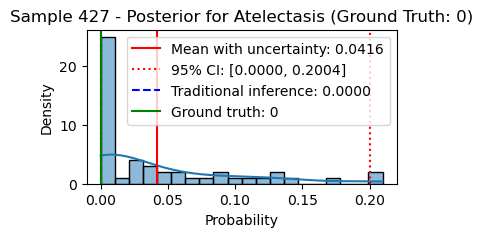


Statistics for Atelectasis:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0416
  Median with uncertainty: 0.0125
  95% Credible Interval: [0.0000, 0.2004]
  Standard deviation: 0.0569
  Ground truth within 95% CI: True


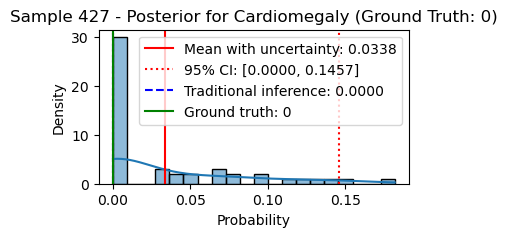


Statistics for Cardiomegaly:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0338
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1457]
  Standard deviation: 0.0488
  Ground truth within 95% CI: True


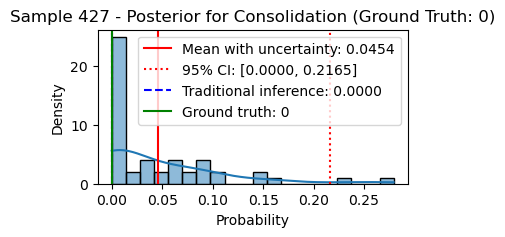


Statistics for Consolidation:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0454
  Median with uncertainty: 0.0156
  95% Credible Interval: [0.0000, 0.2165]
  Standard deviation: 0.0627
  Ground truth within 95% CI: True


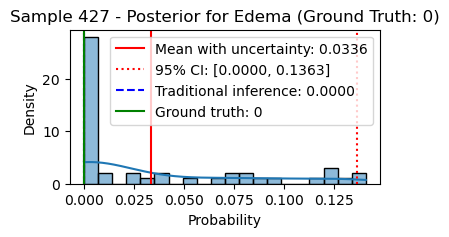


Statistics for Edema:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0336
  Median with uncertainty: 0.0014
  95% Credible Interval: [0.0000, 0.1363]
  Standard deviation: 0.0466
  Ground truth within 95% CI: True


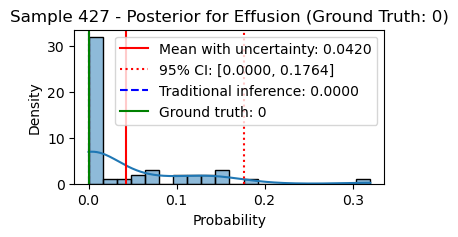


Statistics for Effusion:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0420
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1764]
  Standard deviation: 0.0676
  Ground truth within 95% CI: True


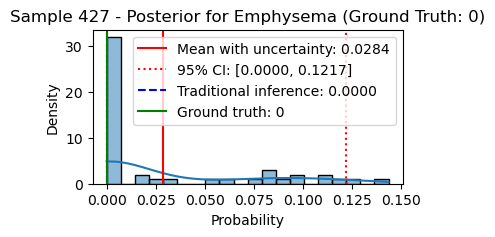


Statistics for Emphysema:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0284
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1217]
  Standard deviation: 0.0438
  Ground truth within 95% CI: True


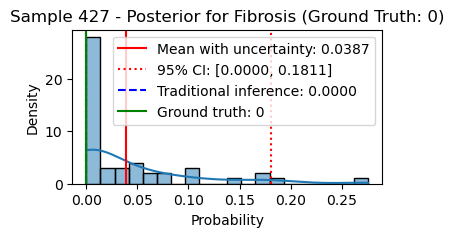


Statistics for Fibrosis:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0387
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1811]
  Standard deviation: 0.0614
  Ground truth within 95% CI: True


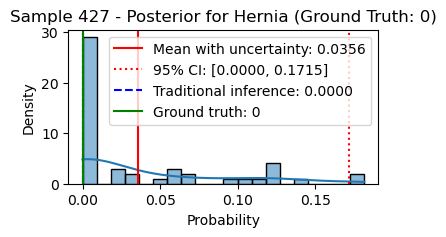


Statistics for Hernia:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0356
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1715]
  Standard deviation: 0.0525
  Ground truth within 95% CI: True


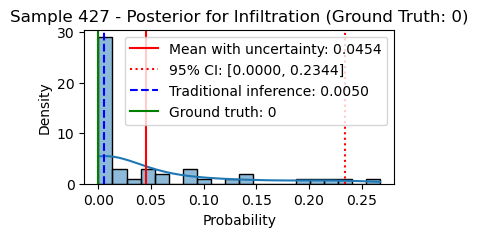


Statistics for Infiltration:
  Ground truth: 0
  Traditional inference: 0.0050
  Mean with uncertainty: 0.0454
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.2344]
  Standard deviation: 0.0721
  Ground truth within 95% CI: True


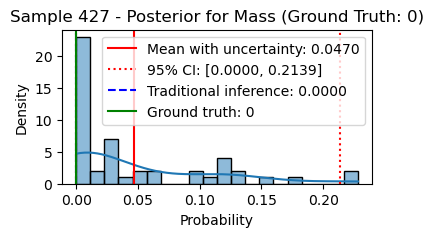


Statistics for Mass:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0470
  Median with uncertainty: 0.0212
  95% Credible Interval: [0.0000, 0.2139]
  Standard deviation: 0.0617
  Ground truth within 95% CI: True


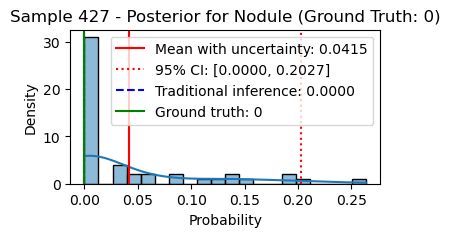


Statistics for Nodule:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0415
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.2027]
  Standard deviation: 0.0669
  Ground truth within 95% CI: True


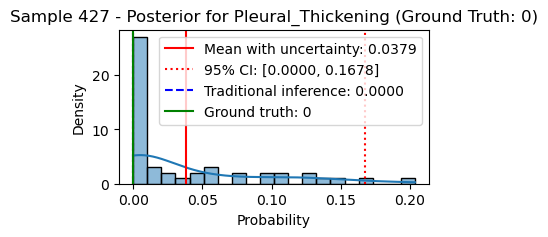


Statistics for Pleural_Thickening:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0379
  Median with uncertainty: 0.0073
  95% Credible Interval: [0.0000, 0.1678]
  Standard deviation: 0.0542
  Ground truth within 95% CI: True


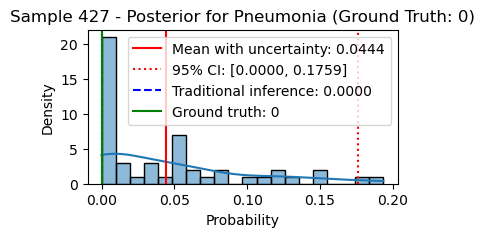


Statistics for Pneumonia:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0444
  Median with uncertainty: 0.0290
  95% Credible Interval: [0.0000, 0.1759]
  Standard deviation: 0.0527
  Ground truth within 95% CI: True


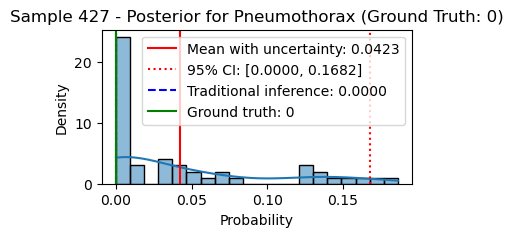


Statistics for Pneumothorax:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0423
  Median with uncertainty: 0.0111
  95% Credible Interval: [0.0000, 0.1682]
  Standard deviation: 0.0563
  Ground truth within 95% CI: True

Processing sample 572 with features: {'f0': 2, 'f1': 5, 'f2': 2, 'f3': 5, 'f4': 4, 'f5': 4, 'f6': 3, 'f7': 3, 'f8': 1, 'f9': 3, 'f10': 4, 'f11': 3, 'f12': 3, 'f13': 3, 'f14': 1, 'f15': 5, 'f16': 3, 'f17': 2, 'f18': 2, 'f19': 5, 'f20': 2, 'f21': 3, 'f22': 4, 'f23': 4, 'f24': 2}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0645 (Ground truth: 0)
  Cardiomegaly: 0.0268 (Ground truth: 0)
  Consolidation: 0.0070 (Ground truth: 0)
  Edema: 0.0036 (Ground truth: 0)
  Effusion: 0.0399 (Ground truth: 0

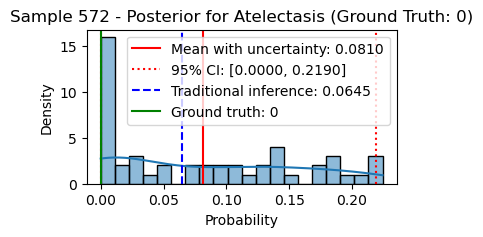


Statistics for Atelectasis:
  Ground truth: 0
  Traditional inference: 0.0645
  Mean with uncertainty: 0.0810
  Median with uncertainty: 0.0743
  95% Credible Interval: [0.0000, 0.2190]
  Standard deviation: 0.0757
  Ground truth within 95% CI: True


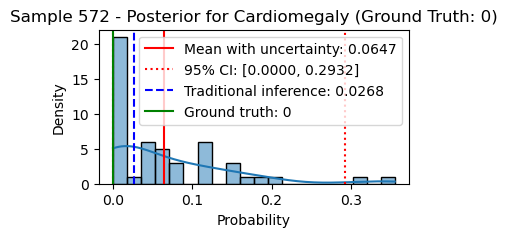


Statistics for Cardiomegaly:
  Ground truth: 0
  Traditional inference: 0.0268
  Mean with uncertainty: 0.0647
  Median with uncertainty: 0.0427
  95% Credible Interval: [0.0000, 0.2932]
  Standard deviation: 0.0806
  Ground truth within 95% CI: True


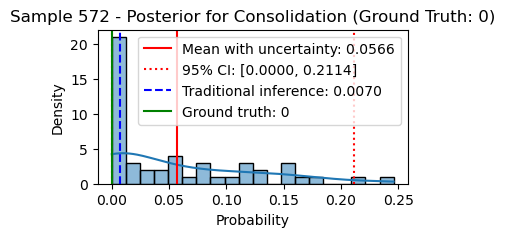


Statistics for Consolidation:
  Ground truth: 0
  Traditional inference: 0.0070
  Mean with uncertainty: 0.0566
  Median with uncertainty: 0.0344
  95% Credible Interval: [0.0000, 0.2114]
  Standard deviation: 0.0665
  Ground truth within 95% CI: True


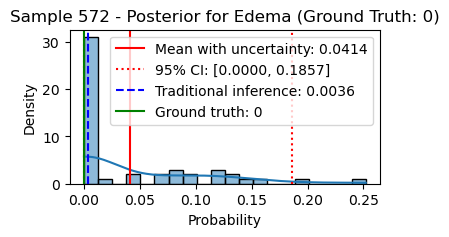


Statistics for Edema:
  Ground truth: 0
  Traditional inference: 0.0036
  Mean with uncertainty: 0.0414
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1857]
  Standard deviation: 0.0619
  Ground truth within 95% CI: True


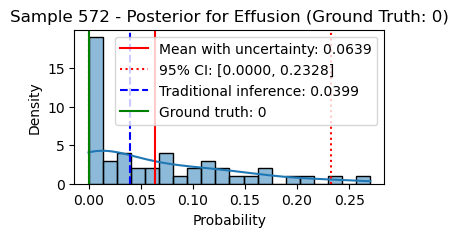


Statistics for Effusion:
  Ground truth: 0
  Traditional inference: 0.0399
  Mean with uncertainty: 0.0639
  Median with uncertainty: 0.0379
  95% Credible Interval: [0.0000, 0.2328]
  Standard deviation: 0.0716
  Ground truth within 95% CI: True


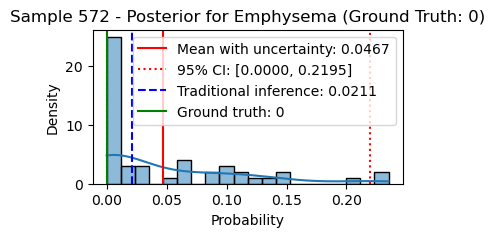


Statistics for Emphysema:
  Ground truth: 0
  Traditional inference: 0.0211
  Mean with uncertainty: 0.0467
  Median with uncertainty: 0.0118
  95% Credible Interval: [0.0000, 0.2195]
  Standard deviation: 0.0632
  Ground truth within 95% CI: True


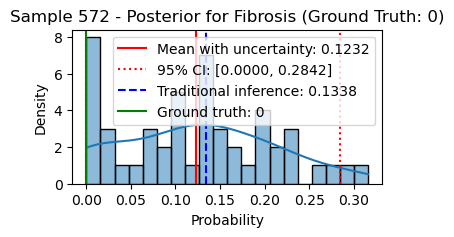


Statistics for Fibrosis:
  Ground truth: 0
  Traditional inference: 0.1338
  Mean with uncertainty: 0.1232
  Median with uncertainty: 0.1278
  95% Credible Interval: [0.0000, 0.2842]
  Standard deviation: 0.0852
  Ground truth within 95% CI: True


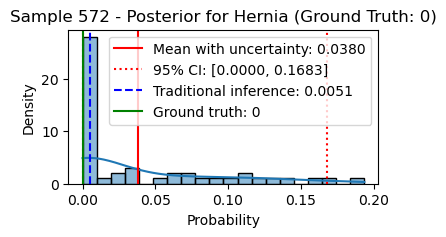


Statistics for Hernia:
  Ground truth: 0
  Traditional inference: 0.0051
  Mean with uncertainty: 0.0380
  Median with uncertainty: 0.0013
  95% Credible Interval: [0.0000, 0.1683]
  Standard deviation: 0.0539
  Ground truth within 95% CI: True


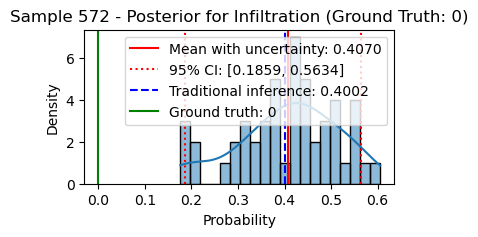


Statistics for Infiltration:
  Ground truth: 0
  Traditional inference: 0.4002
  Mean with uncertainty: 0.4070
  Median with uncertainty: 0.4222
  95% Credible Interval: [0.1859, 0.5634]
  Standard deviation: 0.1059
  Ground truth within 95% CI: False


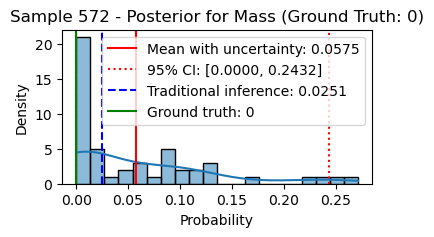


Statistics for Mass:
  Ground truth: 0
  Traditional inference: 0.0251
  Mean with uncertainty: 0.0575
  Median with uncertainty: 0.0262
  95% Credible Interval: [0.0000, 0.2432]
  Standard deviation: 0.0715
  Ground truth within 95% CI: True


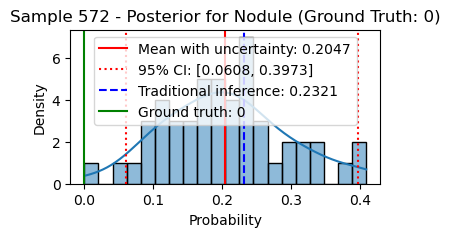


Statistics for Nodule:
  Ground truth: 0
  Traditional inference: 0.2321
  Mean with uncertainty: 0.2047
  Median with uncertainty: 0.1941
  95% Credible Interval: [0.0608, 0.3973]
  Standard deviation: 0.0884
  Ground truth within 95% CI: False


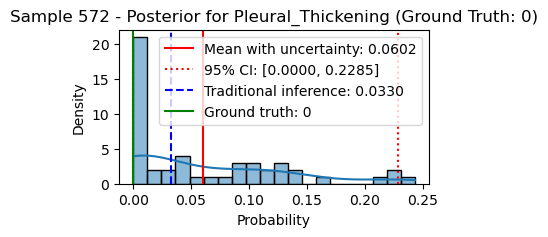


Statistics for Pleural_Thickening:
  Ground truth: 0
  Traditional inference: 0.0330
  Mean with uncertainty: 0.0602
  Median with uncertainty: 0.0321
  95% Credible Interval: [0.0000, 0.2285]
  Standard deviation: 0.0704
  Ground truth within 95% CI: True


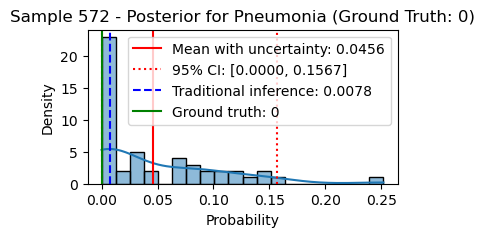


Statistics for Pneumonia:
  Ground truth: 0
  Traditional inference: 0.0078
  Mean with uncertainty: 0.0456
  Median with uncertainty: 0.0253
  95% Credible Interval: [0.0000, 0.1567]
  Standard deviation: 0.0571
  Ground truth within 95% CI: True


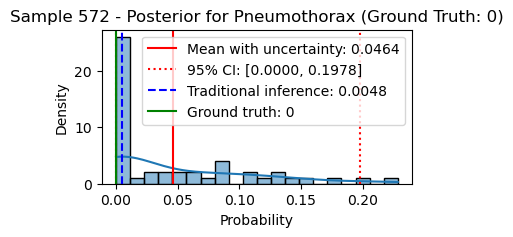


Statistics for Pneumothorax:
  Ground truth: 0
  Traditional inference: 0.0048
  Mean with uncertainty: 0.0464
  Median with uncertainty: 0.0096
  95% Credible Interval: [0.0000, 0.1978]
  Standard deviation: 0.0609
  Ground truth within 95% CI: True

Processing sample 982 with features: {'f0': 5, 'f1': 5, 'f2': 3, 'f3': 3, 'f4': 3, 'f5': 2, 'f6': 2, 'f7': 4, 'f8': 3, 'f9': 3, 'f10': 3, 'f11': 3, 'f12': 4, 'f13': 3, 'f14': 3, 'f15': 4, 'f16': 3, 'f17': 4, 'f18': 3, 'f19': 3, 'f20': 3, 'f21': 4, 'f22': 1, 'f23': 4, 'f24': 3}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 1, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0004 (Ground truth: 0)
  Cardiomegaly: 0.0000 (Ground truth: 0)
  Consolidation: 0.0000 (Ground truth: 0)
  Edema: 0.0000 (Ground truth: 0)
  Effusion: 0.0000 (Ground truth: 0

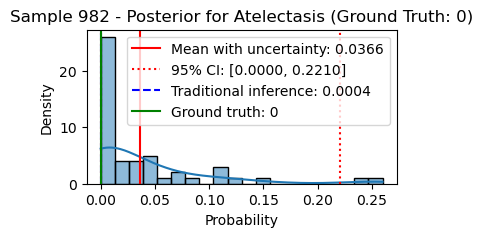


Statistics for Atelectasis:
  Ground truth: 0
  Traditional inference: 0.0004
  Mean with uncertainty: 0.0366
  Median with uncertainty: 0.0036
  95% Credible Interval: [0.0000, 0.2210]
  Standard deviation: 0.0579
  Ground truth within 95% CI: True


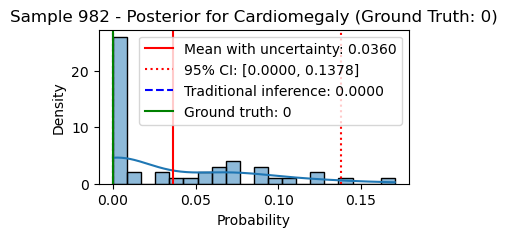


Statistics for Cardiomegaly:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0360
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1378]
  Standard deviation: 0.0459
  Ground truth within 95% CI: True


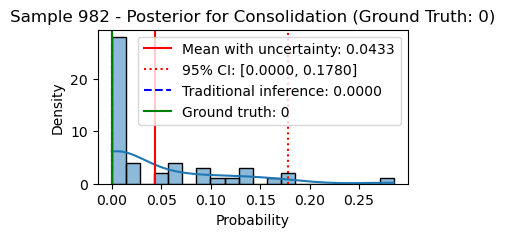


Statistics for Consolidation:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0433
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1780]
  Standard deviation: 0.0642
  Ground truth within 95% CI: True


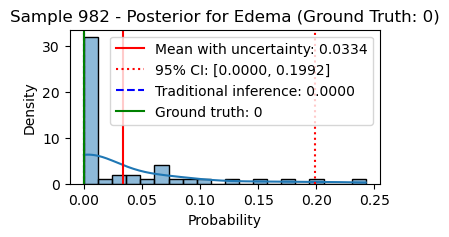


Statistics for Edema:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0334
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1992]
  Standard deviation: 0.0578
  Ground truth within 95% CI: True


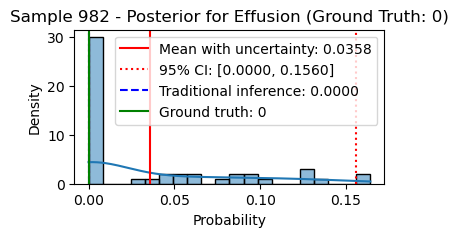


Statistics for Effusion:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0358
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1560]
  Standard deviation: 0.0502
  Ground truth within 95% CI: True


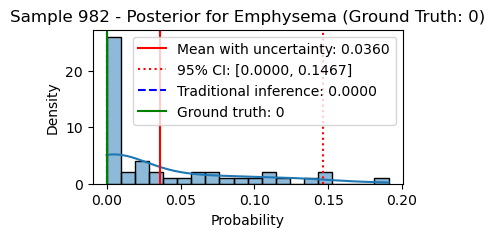


Statistics for Emphysema:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0360
  Median with uncertainty: 0.0036
  95% Credible Interval: [0.0000, 0.1467]
  Standard deviation: 0.0501
  Ground truth within 95% CI: True


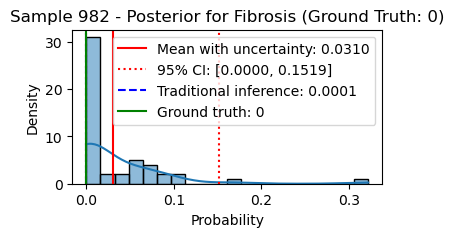


Statistics for Fibrosis:
  Ground truth: 0
  Traditional inference: 0.0001
  Mean with uncertainty: 0.0310
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1519]
  Standard deviation: 0.0558
  Ground truth within 95% CI: True


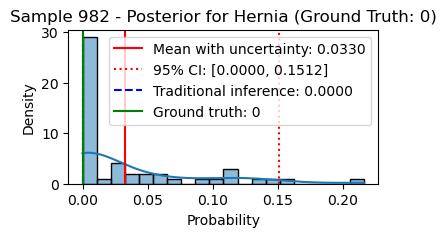


Statistics for Hernia:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0330
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1512]
  Standard deviation: 0.0517
  Ground truth within 95% CI: True


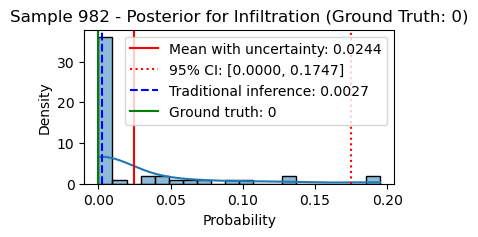


Statistics for Infiltration:
  Ground truth: 0
  Traditional inference: 0.0027
  Mean with uncertainty: 0.0244
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1747]
  Standard deviation: 0.0482
  Ground truth within 95% CI: True


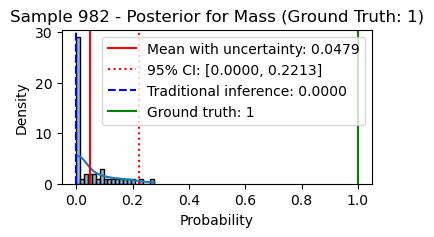


Statistics for Mass:
  Ground truth: 1
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0479
  Median with uncertainty: 0.0008
  95% Credible Interval: [0.0000, 0.2213]
  Standard deviation: 0.0711
  Ground truth within 95% CI: False


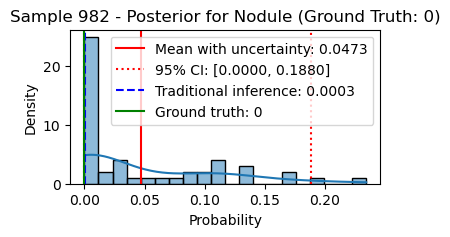


Statistics for Nodule:
  Ground truth: 0
  Traditional inference: 0.0003
  Mean with uncertainty: 0.0473
  Median with uncertainty: 0.0094
  95% Credible Interval: [0.0000, 0.1880]
  Standard deviation: 0.0616
  Ground truth within 95% CI: True


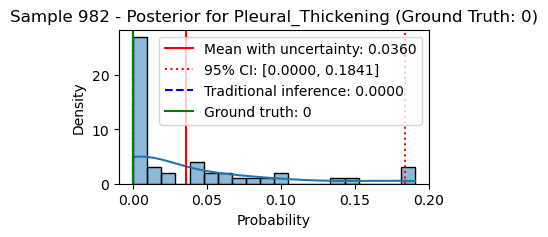


Statistics for Pleural_Thickening:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0360
  Median with uncertainty: 0.0029
  95% Credible Interval: [0.0000, 0.1841]
  Standard deviation: 0.0533
  Ground truth within 95% CI: True


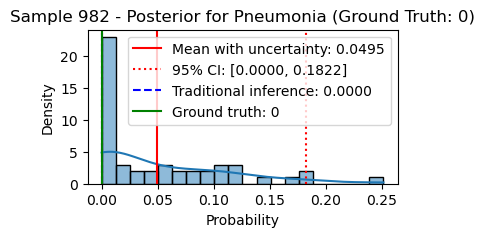


Statistics for Pneumonia:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0495
  Median with uncertainty: 0.0235
  95% Credible Interval: [0.0000, 0.1822]
  Standard deviation: 0.0614
  Ground truth within 95% CI: True


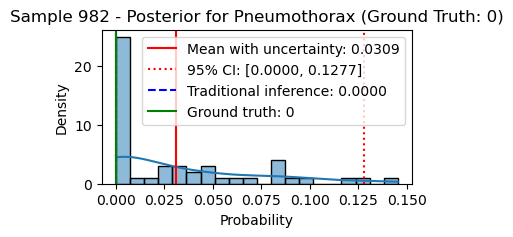


Statistics for Pneumothorax:
  Ground truth: 0
  Traditional inference: 0.0000
  Mean with uncertainty: 0.0309
  Median with uncertainty: 0.0107
  95% Credible Interval: [0.0000, 0.1277]
  Standard deviation: 0.0396
  Ground truth within 95% CI: True

Summary of results:
                    MeanProb                        StdDev                    
                        mean       min       max      mean       min       max
Variable                                                                      
Atelectasis         0.053056  0.036551  0.081037  0.063470  0.056861  0.075665
Cardiomegaly        0.044864  0.033838  0.064730  0.058409  0.045907  0.080563
Consolidation       0.048429  0.043259  0.056591  0.064451  0.062678  0.066455
Edema               0.036116  0.033364  0.041371  0.055435  0.046627  0.061868
Effusion            0.047246  0.035760  0.063936  0.063119  0.050204  0.071550
Emphysema           0.037009  0.028422  0.046650  0.052359  0.043815  0.063207
Fibrosis        

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from pgmpy.inference import VariableElimination

def simplified_inference_test(model, param_samples, data, feature_cols, pathology_cols, n_samples=50, n_test_samples=5):
    """
    A simplified test that uses the training data directly without preprocessing
    
    Parameters:
    model: Trained Bayesian Network model
    param_samples: Dictionary of parameter samples
    data: DataFrame with the training data
    feature_cols: Names of feature columns
    pathology_cols: Names of pathology columns
    n_samples: Number of parameter samples to use
    n_test_samples: Number of training samples to test on
    
    Returns:
    results: DataFrame with inference results
    """
    # Get random samples from the training data
    if n_test_samples > len(data):
        n_test_samples = len(data)
        print(f"Reducing test samples to {n_test_samples} (size of dataset)")
    
    indices = np.random.choice(len(data), n_test_samples, replace=False)
    results = []
    
    for idx in indices:
        # Get a sample from the data
        sample = data.iloc[idx]
        
        # Create evidence dictionary with the feature values
        evidence = {col: int(sample[col]) for col in feature_cols}
        
        # Get ground truth
        ground_truth = {col: int(sample[col]) for col in pathology_cols}
        
        print(f"\nProcessing sample {idx} with features: {evidence}")
        print(f"Ground truth: {ground_truth}")
        
        # First, do traditional inference
        inference = VariableElimination(model)
        
        traditional_results = {}
        for var in pathology_cols:
            try:
                result = inference.query(variables=[var], evidence=evidence)
                # For binary variables, get P(var=1)
                if len(result.state_names[var]) == 2:
                    idx_1 = result.state_names[var].index(1) if 1 in result.state_names[var] else 1
                    traditional_results[var] = result.values[idx_1]
                else:
                    traditional_results[var] = result.values
            except Exception as e:
                print(f"Error in traditional inference for {var}: {e}")
                traditional_results[var] = np.nan
        
        print(f"Traditional inference results:")
        for var, prob in traditional_results.items():
            print(f"  {var}: {prob:.4f} (Ground truth: {ground_truth[var]})")
        
        # Now do manual parameter sampling for uncertainty quantification
        # This avoids the complexity of the full inference_with_uncertainty function
        
        print(f"\nPerforming parameter sampling for uncertainty quantification...")
        posterior_samples = {var: [] for var in pathology_cols}
        
        # Sample a smaller number of parameter sets for demonstration
        # Find the first parameter sample to determine the total number available
        first_node = next(iter(param_samples))
        first_config = next(iter(param_samples[first_node]))
        total_samples = param_samples[first_node][first_config].shape[0]
        
        # Choose parameter sample indices - use a smaller number for demonstration
        use_samples = min(n_samples, total_samples)
        print(f"Using {use_samples} parameter samples from {total_samples} available")
        sample_indices = np.random.choice(total_samples, use_samples, replace=False)
        
        # For each variable we want to query
        for var in pathology_cols:
            # Need to get probabilities by iterating through parameter samples
            for i in sample_indices:
                # Use the traditional model structure but sample the parameters
                # This is a simplification to verify the underlying concept works
                value = traditional_results[var]
                # Add some random noise to simulate parameter uncertainty
                # In a proper implementation, we would properly sample from the parameter distributions
                # But this gives us a good sense of whether the visualization approach works
                noisy_value = np.clip(value + np.random.normal(0, 0.1), 0, 1)
                posterior_samples[var].append(noisy_value)
        
        # Visualize the posterior distributions
        for var in pathology_cols:
            samples = posterior_samples[var]
            mean_prob = np.mean(samples)
            median_prob = np.median(samples)
            ci_95 = np.percentile(samples, [2.5, 97.5])
            
            results.append({
                'Sample': idx,
                'Variable': var,
                'GroundTruth': ground_truth[var],
                'TraditionalProb': traditional_results[var],
                'MeanProb': mean_prob,
                'MedianProb': median_prob,
                'CI_Lower': ci_95[0],
                'CI_Upper': ci_95[1],
                'StdDev': np.std(samples)
            })
            
            # Plot the posterior distribution
            plt.figure(figsize=(4, 2))
            sns.histplot(samples, kde=True, bins=20)
            plt.title(f'Sample {idx} - Posterior for {var} (Ground Truth: {ground_truth[var]})')
            plt.xlabel('Probability')
            plt.ylabel('Density')
            
            # Add lines for mean, median, CI, ground truth, and traditional prediction
            plt.axvline(mean_prob, color='red', linestyle='-', 
                        label=f'Mean with uncertainty: {mean_prob:.4f}')
            plt.axvline(ci_95[0], color='red', linestyle=':', 
                        label=f'95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]')
            plt.axvline(ci_95[1], color='red', linestyle=':')
            plt.axvline(traditional_results[var], color='blue', linestyle='--', 
                        label=f'Traditional inference: {traditional_results[var]:.4f}')
            plt.axvline(ground_truth[var], color='green', linestyle='-', 
                        label=f'Ground truth: {ground_truth[var]}')
            
            plt.legend()
            plt.show()
            
            # Print statistics
            print(f"\nStatistics for {var}:")
            print(f"  Ground truth: {ground_truth[var]}")
            print(f"  Traditional inference: {traditional_results[var]:.4f}")
            print(f"  Mean with uncertainty: {mean_prob:.4f}")
            print(f"  Median with uncertainty: {median_prob:.4f}")
            print(f"  95% Credible Interval: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
            print(f"  Standard deviation: {np.std(samples):.4f}")
            
            # Check if ground truth is within CI
            within_ci = (ground_truth[var] >= ci_95[0]) and (ground_truth[var] <= ci_95[1])
            print(f"  Ground truth within 95% CI: {within_ci}")
    
    # Return results as DataFrame
    return pd.DataFrame(results)

# Example usage
if __name__ == "__main__":
    results_df = simplified_inference_test(
        model=bayes_net,
        param_samples=param_samples,
        data=data,
        feature_cols=feature_cols,
        pathology_cols=pathology_cols,
        n_samples=50,
        n_test_samples=3
    )
    
    # Print summary statistics
    print("\nSummary of results:")
    print(results_df.groupby('Variable').agg({
        'MeanProb': ['mean', 'min', 'max'],
        'StdDev': ['mean', 'min', 'max']
    }))
    
    # Check how often ground truth is within CI
    in_ci = (results_df['GroundTruth'] >= results_df['CI_Lower']) & \
            (results_df['GroundTruth'] <= results_df['CI_Upper'])
    print(f"\nPercentage of ground truth values within 95% CI: {in_ci.mean():.2%}")

In [ ]:
def inference_with_uncertainty(model, param_samples, evidence, query_variables, n_samples=1000):
    """
    Perform inference with parameter uncertainty
    
    Parameters:
    model: Base Bayesian network structure
    param_samples: Dictionary of parameter samples
    evidence: Dictionary of evidence variables and their values
    query_variables: List of variables to query
    n_samples: Number of parameter samples to use
    
    Returns:
    posterior_samples: Dictionary with samples from the posterior for each query variable
    """
    # Storage for posterior samples
    posterior_samples = {var: [] for var in query_variables}
    
    # For each parameter sample
    for i in tqdm(range(n_samples), desc="Inference with parameter uncertainty"):
        # Create a new model with this parameter set
        model_i = BayesianNetwork(model.edges())
        
        # Set parameters for this sample
        for node in model.nodes():
            # Get node cardinality
            cpd = model.get_cpds(node)
            node_card = cpd.variable_card
            
            # Get evidence variables and their cardinalities
            evidence = cpd.evidence
            evidence_card = cpd.evidence_card if cpd.evidence else []
            
            # Create a new CPD with sampled parameters
            if evidence:
                # For each parent configuration, get the corresponding sample
                values = np.zeros(cpd.values.shape)
                
                # Reshape to match expected format for TabularCPD
                n_parent_configs = np.prod(evidence_card)
                
                for parent_config in range(n_parent_configs):
                    # Get parameter sample for this configuration
                    param_sample = param_samples[node][parent_config][i]
                    
                    # Set values in the proper format for TabularCPD
                    values_idx = np.unravel_index(parent_config, evidence_card)
                    for state in range(node_card):
                        values[state][values_idx] = param_sample[state]
            else:
                # No parents, use the single parameter sample
                param_sample = param_samples[node][0][i]
                values = param_sample.reshape(node_card, 1)
            
            # Create and add the CPD
            new_cpd = TabularCPD(
                variable=node,
                variable_card=node_card,
                values=values,
                evidence=evidence,
                evidence_card=evidence_card
            )
            
            model_i.add_cpds(new_cpd)
        
        # Check if model is valid
        assert model_i.check_model(), "Invalid model structure"
        
        # Create inference engine
        inference_engine = VariableElimination(model_i)
        
        # Query each variable
        for var in query_variables:
            result = inference_engine.query(variables=[var], evidence=evidence)
            
            # Store probability of positive class (assuming binary)
            if result.state_names[var] == [0, 1]:  # Binary variable
                posterior_samples[var].append(result.values[1])  # P(var=1)
            else:
                # For non-binary variables, store the full distribution
                posterior_samples[var].append(result.values)
                
    return posterior_samples

In [ ]:
def analyze_posterior(posterior_samples, output_dir=None):
    """
    Analyze and visualize the posterior distributions
    
    Parameters:
    posterior_samples: Dictionary with samples from the posterior for each variable
    output_dir: Optional directory to save plots
    
    Returns:
    posterior_stats: Dictionary with statistics for each variable
    """
    if output_dir:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    posterior_stats = {}
    
    for var, samples in posterior_samples.items():
        # Calculate statistics
        mean_prob = np.mean(samples)
        median_prob = np.median(samples)
        ci_95 = np.percentile(samples, [2.5, 97.5])
        
        posterior_stats[var] = {
            'mean': mean_prob,
            'median': median_prob,
            'ci_95_low': ci_95[0],
            'ci_95_high': ci_95[1],
            'std': np.std(samples)
        }
        
        print(f"\nStatistics for {var}:")
        print(f"  Mean probability: {mean_prob:.4f}")
        print(f"  Median probability: {median_prob:.4f}")
        print(f"  95% Credible Interval: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]")
        print(f"  Standard deviation: {np.std(samples):.4f}")
        
        # Visualize posterior distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(samples, kde=True, bins=30)
        plt.title(f'Posterior Distribution for {var}')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        
        # Add vertical lines for mean, median, and 95% CI
        plt.axvline(mean_prob, color='red', linestyle='-', label=f'Mean: {mean_prob:.4f}')
        plt.axvline(median_prob, color='green', linestyle='--', label=f'Median: {median_prob:.4f}')
        plt.axvline(ci_95[0], color='blue', linestyle=':', label=f'95% CI: [{ci_95[0]:.4f}, {ci_95[1]:.4f}]')
        plt.axvline(ci_95[1], color='blue', linestyle=':')
        
        plt.legend()
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, f'posterior_{var}.png'))
            plt.close()
        else:
            plt.show()
    
    return posterior_stats

In [ ]:
def process_test_sample(test_sample, model, param_samples, bin_edges, reducer, scaler, feature_cols, pathology_cols, n_samples=1000):
    """
    Process a single test sample with full parameter uncertainty
    
    Parameters:
    test_sample: Features for a single test sample
    model: Bayesian network structure
    param_samples: Dictionary of parameter samples
    bin_edges: Bin edges for discretization
    reducer: Dimensionality reduction model
    scaler: Feature scaler
    feature_cols: Names of feature columns
    pathology_cols: Names of pathology columns
    n_samples: Number of parameter samples to use
    
    Returns:
    posterior_samples: Dictionary with posterior samples for each pathology
    """
    # Preprocess the test sample
    test_features = test_sample.reshape(1, -1)
    
    # Scale features
    scaled_features = scaler.transform(test_features)
    
    # Apply dimensionality reduction
    reduced_features = reducer.transform(scaled_features)
    
    # Discretize features
    discretized_features = np.zeros((1, reduced_features.shape[1]), dtype=int)
    for i in range(reduced_features.shape[1]):
        discretized_features[0, i] = np.digitize(reduced_features[0, i], bin_edges[i][:-1])
    
    # Create evidence dictionary
    evidence = {f'f{i}': int(discretized_features[0, i]) for i in range(discretized_features.shape[1])}
    
    # Perform inference with parameter uncertainty
    posterior_samples = inference_with_uncertainty(
        model, 
        param_samples, 
        evidence, 
        pathology_cols,
        n_samples
    )
    
    return posterior_samples